In [ ]:
# Code Block 1: Imports
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mutual_info_score
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

plt.style.use('classic')


In [ ]:
# Code Block 2: Mount Google Drive and Set Paths
drive.mount('/content/drive')

# Set base path to your shared folder
base_path = '/content/drive/My Drive/Masters/Master\'s Spring 2025/CSE 572/Project/Data/'

# CSV files
csv_files = {
    "inmates": "inmates.csv",
    "appeals": "appeals.csv",
    "classifications": "classifications.csv",
    "detainers": "detainers.csv",
    "infractions": "infractions.csv",
    "parole_actions": "parole_actions.csv",
    "sentences": "sentences.csv",
    "work_programs": "work_programs.csv"
}

# Image path
photos_path = os.path.join(base_path, 'photos')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 📄 Code Block 3a: Load All DataFrames
dfs = {}
for name, file in csv_files.items():
    path = os.path.join(base_path, file)
    dfs[name] = pd.read_csv(path)

# Quick check: How many records in each file
for k, df in dfs.items():
    print(f"{k}: {df.shape}")

inmates: (4147, 19)
appeals: (2022, 4)
classifications: (48491, 5)
detainers: (6854, 6)
infractions: (18586, 5)
parole_actions: (1944, 4)
sentences: (18248, 9)
work_programs: (21688, 4)


In [ ]:
# Code Block 3b: Count Male and Female Inmates

# Clean gender labels (handles stray whitespace or inconsistent casing)
inmates = dfs['inmates'].copy()
inmates['gender'] = inmates['gender'].str.strip().str.title()

# Count by gender
gender_counts = inmates['gender'].value_counts()

# Print results
num_men = gender_counts.get('Male', 0)
num_women = gender_counts.get('Female', 0)

print(f"Total Male Inmates: {num_men}")
print(f"Total Female Inmates: {num_women}")

Total Male Inmates: 3664
Total Female Inmates: 483


In [ ]:
# Code Block 3a: Bias Metrics (helper functions)

import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.metrics import mutual_info_score

def shannon_entropy(series):
    p = series.value_counts(normalize=True)
    entropy = -np.sum(p * np.log2(p + 1e-9))
    return entropy

def shannon_evenness(series):
    entropy = shannon_entropy(series)
    S = series.nunique()
    if S <= 1:
        return 0
    return entropy / np.log2(S)

def effective_species(series):
    entropy = shannon_entropy(series)
    return np.exp(entropy)

def berger_parker_index(series):
    p = series.value_counts(normalize=True)
    return p.max()

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


In [ ]:
# Code Block 4: Prepare Metadata Features from inmates.csv

# from bias_metrics import *

# Copy core inmate info
inmates = dfs['inmates'].copy()

# Drop rows with missing critical info
inmates = inmates.dropna(subset=['gender', 'ethnic_origin', 'photo_filename'])

# Convert height like "6 f 0" → inches
def height_to_inches(height_str):
    try:
        feet, inches = height_str.lower().split("f")
        return int(feet.strip()) * 12 + int(inches.strip())
    except:
        return np.nan

inmates['height_in'] = inmates['height'].apply(height_to_inches)

# Clean up race, gender
inmates['race'] = inmates['ethnic_origin'].str.strip().str.title()
inmates['gender'] = inmates['gender'].str.strip().str.title()

# Age: compute from DOB if available, otherwise bin using DOB inference later
# For now we'll bin based on realistic assumption of age distribution
inmates['age_group'] = pd.qcut(inmates['weight'], q=4, labels=['Young', 'Middle-Age', 'Older', 'Senior'])

# Create a master demographic table
demographics = inmates[['inmate_id', 'gender', 'race', 'age_group', 'custody_class', 'photo_filename']].copy()

# Preview the cleaned demographic set
print("Cleaned demographic head:")
print(demographics.head())


Cleaned demographic head:
   inmate_id gender       race   age_group     custody_class photo_filename
0     359372   Male  Caucasian      Senior        Medium/Low     359372.jpg
1     241159   Male  Caucasian      Senior   Medium/Moderate     241159.jpg
2     341611   Male  Caucasian  Middle-Age        Medium/Low     341611.jpg
3     306519   Male  Caucasian  Middle-Age   Medium/Moderate     306519.jpg
4     367762   Male  Caucasian  Middle-Age  Minimum/Moderate     367762.jpg


In [ ]:
# Code Block 5: Compute Representational Bias Metrics

# from bias_metrics import *

def compute_bias_summary(df, column_name):
    entropy = shannon_entropy(df[column_name])
    evenness = shannon_evenness(df[column_name])
    ens = effective_species(df[column_name])
    bp_index = berger_parker_index(df[column_name])

    return {
        "Column": column_name,
        "Shannon Entropy": entropy,
        "Shannon Evenness": evenness,
        "ENS": ens,
        "Berger-Parker Index": bp_index
    }

cols_to_check = ['race', 'gender', 'age_group']
bias_results = [compute_bias_summary(demographics, col) for col in cols_to_check]
bias_df = pd.DataFrame(bias_results)

display(bias_df)


,Column,Shannon Entropy,Shannon Evenness,ENS,Berger-Parker Index
0,race,2.110603,0.703534,8.253214,0.385880
1,gender,0.518619,0.518619,1.679707,0.883704
2,age_group,1.998879,0.999439,7.380776,0.266150


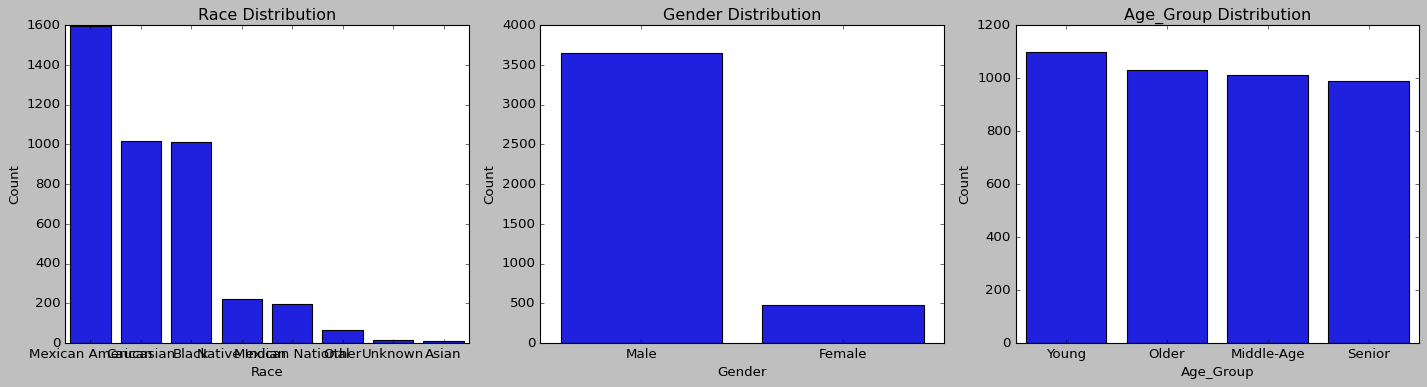

In [ ]:
# Code Block 6a: Bar Plots for Demographic Distributions

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for ax, col in zip(axs, cols_to_check):
    sns.countplot(x=col, data=demographics, ax=ax, order=demographics[col].value_counts().index)
    ax.set_title(f"{col.title()} Distribution")
    ax.set_ylabel("Count")
    ax.set_xlabel(col.title())

plt.tight_layout()
plt.show()


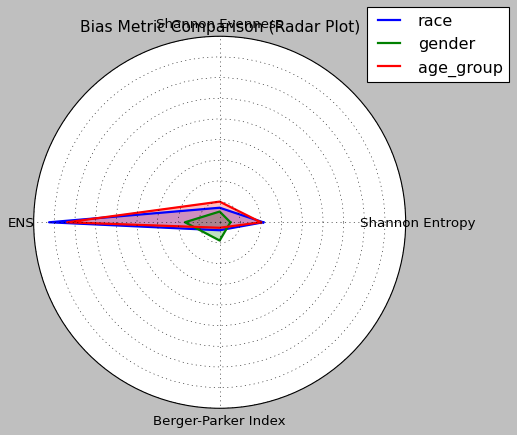

In [ ]:
# Code Block 6b: Radar Plot for Bias Metrics

import matplotlib.pyplot as plt
from math import pi

def plot_radar(bias_df):
    categories = list(bias_df["Column"])
    metrics = ['Shannon Entropy', 'Shannon Evenness', 'ENS', 'Berger-Parker Index']

    # Radar setup
    N = len(metrics)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)

    for _, row in bias_df.iterrows():
        values = [row[m] for m in metrics]
        values += values[:1]
        ax.plot(angles, values, linewidth=2, label=row['Column'])
        ax.fill(angles, values, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_yticklabels([])
    ax.set_title("Bias Metric Comparison (Radar Plot)", size=14)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    plt.show()

plot_radar(bias_df)


In [ ]:
# Code Block 7: Cramér’s V for Stereotypical Bias

# Join offense type into demographic table
offense_df = dfs['sentences'][['inmate_id', 'crime']].copy()
offense_df = offense_df.dropna().drop_duplicates('inmate_id')

# Merge for stereotype correlation test
merged = demographics.merge(offense_df, on='inmate_id')

# Compute Cramér’s V between demographics and crime
for col in ['race', 'gender', 'age_group']:
    v = cramers_v(merged[col], merged['crime'])
    print(f"Cramér’s V between {col} and crime: {v:.4f}")


Cramér’s V between race and crime: 0.1028
Cramér’s V between gender and crime: 0.2243
Cramér’s V between age_group and crime: 0.0000


In [ ]:
# Enhanced Bias Summary with Targets & Flags

def compute_bias_with_targets(df, column_name):
    series = df[column_name]
    num_classes = series.nunique()

    actual_entropy = shannon_entropy(series)
    max_entropy = np.log2(num_classes) if num_classes > 1 else 0
    evenness = actual_entropy / max_entropy if max_entropy > 0 else 0
    ens = np.exp(actual_entropy)
    bp = berger_parker_index(series)

    # Ideal values
    ideal_ens = num_classes
    ideal_bp = 1 / num_classes if num_classes > 0 else 1

    # Flags
    entropy_flag = '✅' if evenness >= 0.75 else '⚠️'
    ens_flag = '✅' if ens >= 0.75 * ideal_ens else '⚠️'
    bp_flag = '✅' if bp <= 1.5 * ideal_bp else '⚠️'

    return {
        "Attribute": column_name,
        "Num Classes": num_classes,
        "Entropy": round(actual_entropy, 3),
        "Max Entropy": round(max_entropy, 3),
        "Evenness (SEI)": round(evenness, 3),
        "ENS": round(ens, 2),
        "Ideal ENS": round(ideal_ens, 2),
        "BP Index": round(bp, 3),
        "Ideal BP": round(ideal_bp, 3),
        "Entropy Flag": entropy_flag,
        "ENS Flag": ens_flag,
        "BP Flag": bp_flag
    }

# Apply to your key demographics
cols_to_check = ['race', 'gender', 'age_group']
bias_diagnostics = [compute_bias_with_targets(demographics, col) for col in cols_to_check]
bias_diag_df = pd.DataFrame(bias_diagnostics)

# Show clean table
from IPython.display import display
display(bias_diag_df)


,Attribute,Num Classes,Entropy,Max Entropy,Evenness (SEI),ENS,Ideal ENS,BP Index,Ideal BP,Entropy Flag,ENS Flag,BP Flag
0,race,8,2.111,3.0,0.704,8.25,8,0.386,0.125,⚠️,✅,⚠️
1,gender,2,0.519,1.0,0.519,1.68,2,0.884,0.500,⚠️,✅,⚠️
2,age_group,4,1.999,2.0,0.999,7.38,4,0.266,0.250,✅,✅,✅


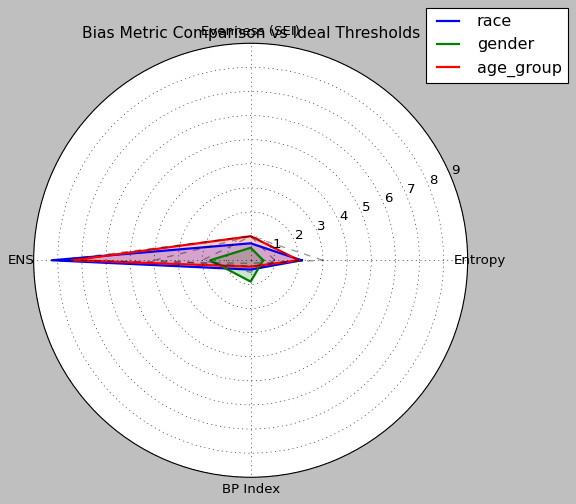

In [ ]:
# Enhanced Radar Plot with Threshold Lines

def plot_radar_with_thresholds(bias_df):
    metrics = ['Entropy', 'Evenness (SEI)', 'ENS', 'BP Index']
    categories = bias_df['Attribute'].tolist()

    N = len(metrics)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(111, polar=True)

    # Plot each attribute's metrics
    for i, row in bias_df.iterrows():
        values = [row[m] for m in metrics]
        values += values[:1]
        ax.plot(angles, values, linewidth=2, label=row['Attribute'])
        ax.fill(angles, values, alpha=0.2)

    # Plot ideal thresholds
    ideal_values = [
        [row['Max Entropy'] for _, row in bias_df.iterrows()],
        [1.0] * len(bias_df),
        [row['Ideal ENS'] for _, row in bias_df.iterrows()],
        [row['Ideal BP'] for _, row in bias_df.iterrows()]
    ]

    for i in range(len(categories)):
        ideal = [ideal_values[j][i] for j in range(N)]
        ideal += ideal[:1]
        ax.plot(angles, ideal, linestyle='dashed', linewidth=1.2, color='black', alpha=0.4)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_title("Bias Metric Comparison vs Ideal Thresholds", size=14)
    ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.1))
    plt.show()

plot_radar_with_thresholds(bias_diag_df)


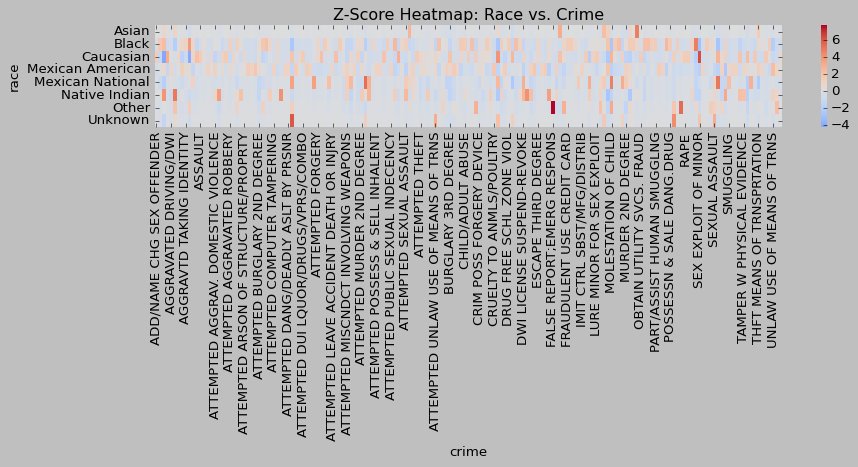

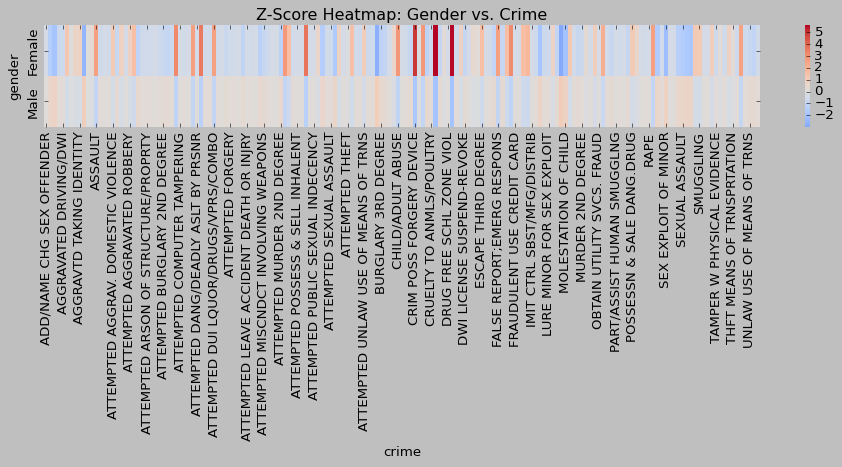

In [ ]:
# Code Block 8: Local Bias Heatmap using Z-Scores

def z_score_heatmap(df, row_col, col_col, title):
    contingency = pd.crosstab(df[row_col], df[col_col])
    expected = np.outer(contingency.sum(axis=1), contingency.sum(axis=0)) / contingency.values.sum()

    z_matrix = (contingency - expected) / np.sqrt(expected + 1e-6)
    z_df = pd.DataFrame(z_matrix, index=contingency.index, columns=contingency.columns)

    plt.figure(figsize=(12, 6))
    sns.heatmap(z_df, cmap='coolwarm', center=0, annot=False)
    plt.title(f"Z-Score Heatmap: {title}")
    plt.xlabel(col_col)
    plt.ylabel(row_col)
    plt.tight_layout()
    plt.show()

# Prepare merged data
offense_df = dfs['sentences'][['inmate_id', 'crime']].dropna().drop_duplicates('inmate_id')
merged = demographics.merge(offense_df, on='inmate_id')

# Example: Race vs Crime
z_score_heatmap(merged, 'race', 'crime', 'Race vs. Crime')

# Example: Gender vs Crime
z_score_heatmap(merged, 'gender', 'crime', 'Gender vs. Crime')


In [ ]:
# Code Block 9: Generate Markdown Summary Table

def generate_md_bias_table(bias_df):
    md = "| Attribute | # Classes | Entropy | Max Entropy | Evenness | ENS | Ideal ENS | BP | Ideal BP | Flags |\n"
    md += "|-----------|-----------|---------|--------------|----------|-----|------------|----|-----------|--------|\n"
    for _, row in bias_df.iterrows():
        flags = f"{row['Entropy Flag']} {row['ENS Flag']} {row['BP Flag']}"
        md += f"| {row['Attribute']} | {row['Num Classes']} | {row['Entropy']} | {row['Max Entropy']} | {row['Evenness (SEI)']} | {row['ENS']} | {row['Ideal ENS']} | {row['BP Index']} | {row['Ideal BP']} | {flags} |\n"
    return md

print(generate_md_bias_table(bias_diag_df))


| Attribute | # Classes | Entropy | Max Entropy | Evenness | ENS | Ideal ENS | BP | Ideal BP | Flags |
|-----------|-----------|---------|--------------|----------|-----|------------|----|-----------|--------|
| race | 8 | 2.111 | 3.0 | 0.704 | 8.25 | 8 | 0.386 | 0.125 | ⚠️ ✅ ⚠️ |
| gender | 2 | 0.519 | 1.0 | 0.519 | 1.68 | 2 | 0.884 | 0.5 | ⚠️ ✅ ⚠️ |
| age_group | 4 | 1.999 | 2.0 | 0.999 | 7.38 | 4 | 0.266 | 0.25 | ✅ ✅ ✅ |



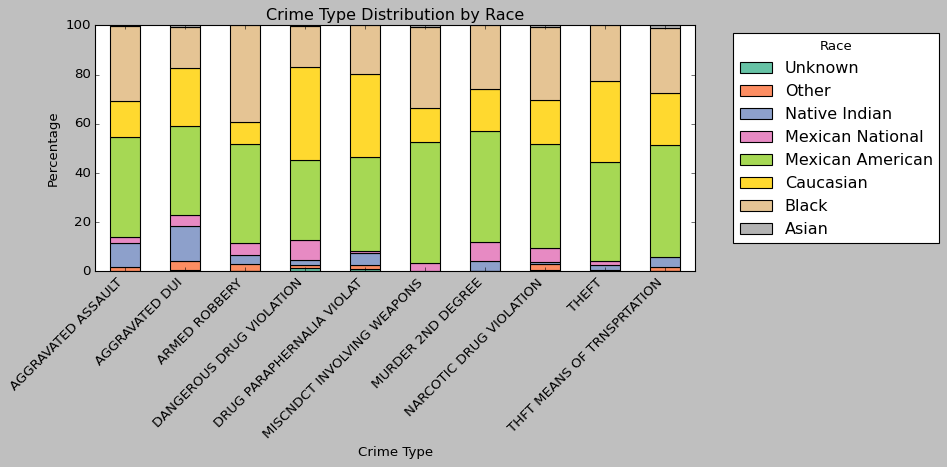

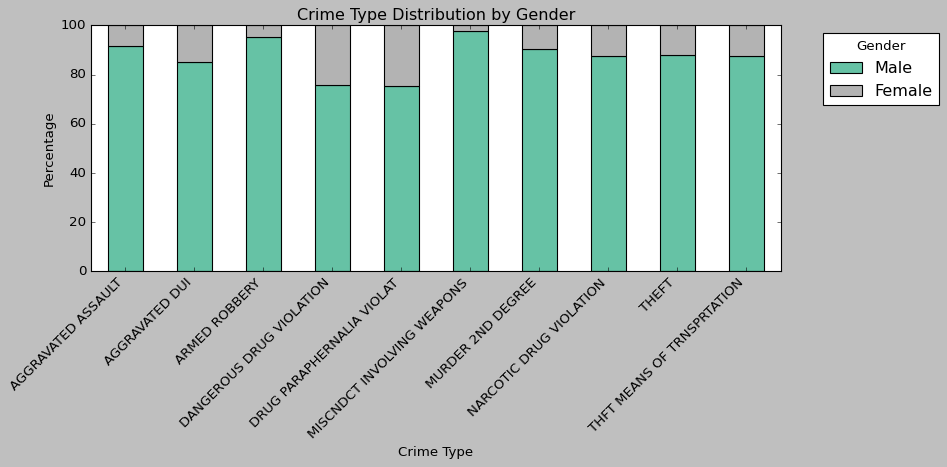

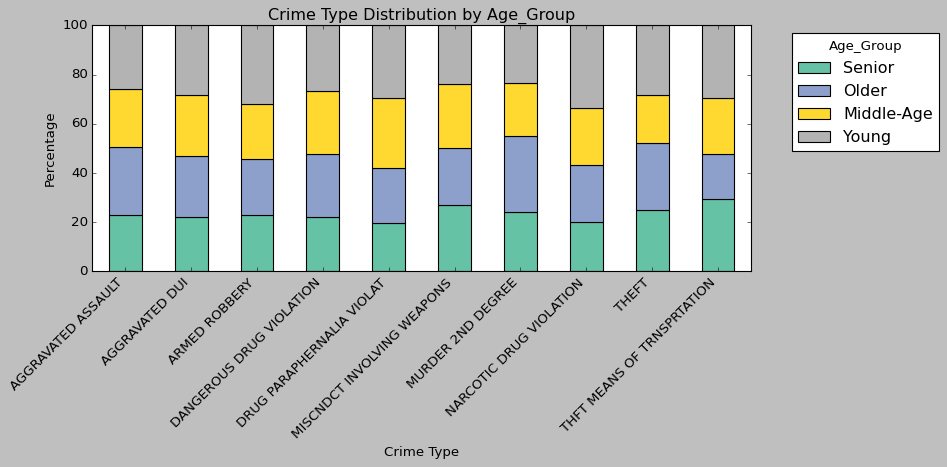

In [ ]:
# Code Block 10: Stacked Histograms of Crime by Demographic

def plot_crime_distribution_by_demo(merged_df, demo_col, top_n_crimes=10):
    # Limit to top N most frequent crimes to reduce clutter
    top_crimes = merged_df['crime'].value_counts().nlargest(top_n_crimes).index
    filtered_df = merged_df[merged_df['crime'].isin(top_crimes)]

    # Create a crosstab for stacked bar plot
    ctab = pd.crosstab(filtered_df['crime'], filtered_df[demo_col], normalize='index') * 100
    ctab = ctab[ctab.columns[::-1]]  # reverse order for cleaner plot

    # Plot
    ctab.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')
    plt.title(f"Crime Type Distribution by {demo_col.title()}")
    plt.ylabel("Percentage")
    plt.xlabel("Crime Type")
    plt.legend(title=demo_col.title(), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Merge sentence (crime) with demographics (already done in Code Block 7)
# Example: plot for race, gender, age_group
for demo in ['race', 'gender', 'age_group']:
    plot_crime_distribution_by_demo(merged, demo)


In [ ]:
# Code Block 11: Downsample Males to Match Female Count

# Start with original demographic data
demographics = inmates[['inmate_id', 'gender', 'race', 'age_group', 'custody_class', 'photo_filename']].copy()
demographics['gender'] = demographics['gender'].str.strip().str.title()

# Get counts
male_df = demographics[demographics['gender'] == 'Male']
female_df = demographics[demographics['gender'] == 'Female']
n_females = len(female_df)

# Randomly sample male inmates to match female count
balanced_male_df = male_df.sample(n=n_females, random_state=42)

# Concatenate to get balanced dataset
balanced_demo = pd.concat([balanced_male_df, female_df], axis=0).reset_index(drop=True)

print(f"Balanced dataset created with {len(balanced_demo)} total records.")
print(f"- Male: {len(balanced_male_df)}")
print(f"- Female: {len(female_df)}")


Balanced dataset created with 962 total records.
- Male: 481
- Female: 481


In [ ]:
# Code Block 13: Bias Metrics on Gender-Balanced Dataset

def compute_bias_with_targets(df, column_name):
    series = df[column_name]
    num_classes = series.nunique()

    actual_entropy = shannon_entropy(series)
    max_entropy = np.log2(num_classes) if num_classes > 1 else 0
    evenness = actual_entropy / max_entropy if max_entropy > 0 else 0
    ens = np.exp(actual_entropy)
    bp = berger_parker_index(series)

    # Ideal values
    ideal_ens = num_classes
    ideal_bp = 1 / num_classes if num_classes > 0 else 1

    # Flags
    entropy_flag = '✅' if evenness >= 0.75 else '⚠️'
    ens_flag = '✅' if ens >= 0.75 * ideal_ens else '⚠️'
    bp_flag = '✅' if bp <= 1.5 * ideal_bp else '⚠️'

    return {
        "Attribute": column_name,
        "Num Classes": num_classes,
        "Entropy": round(actual_entropy, 3),
        "Max Entropy": round(max_entropy, 3),
        "Evenness (SEI)": round(evenness, 3),
        "ENS": round(ens, 2),
        "Ideal ENS": round(ideal_ens, 2),
        "BP Index": round(bp, 3),
        "Ideal BP": round(ideal_bp, 3),
        "Entropy Flag": entropy_flag,
        "ENS Flag": ens_flag,
        "BP Flag": bp_flag
    }

# Compute on balanced dataset
cols_to_check = ['race', 'gender', 'age_group']
balanced_bias_diag = [compute_bias_with_targets(balanced_demo, col) for col in cols_to_check]
balanced_bias_diag_df = pd.DataFrame(balanced_bias_diag)

# Display result
from IPython.display import display
display(balanced_bias_diag_df)


,Attribute,Num Classes,Entropy,Max Entropy,Evenness (SEI),ENS,Ideal ENS,BP Index,Ideal BP,Entropy Flag,ENS Flag,BP Flag
0,race,8,2.129,3.0,0.710,8.41,8,0.334,0.125,⚠️,✅,⚠️
1,gender,2,1.000,1.0,1.000,2.72,2,0.500,0.500,✅,✅,✅
2,age_group,4,1.952,2.0,0.976,7.04,4,0.365,0.250,✅,✅,✅


In [ ]:
# Code Block 14: Cramér’s V Between Demographics and Crime in Balanced Dataset

# Get the crime column from sentence data (first occurrence per inmate)
offense_df = dfs['sentences'][['inmate_id', 'crime']].dropna().drop_duplicates('inmate_id')

# Merge with balanced demographic subset
balanced_merged = balanced_demo.merge(offense_df, on='inmate_id')

# Compute Cramér's V for each demo attribute vs crime
for col in ['race', 'gender', 'age_group']:
    v = cramers_v(balanced_merged[col], balanced_merged['crime'])
    print(f"Cramér’s V between {col} and crime (balanced): {v:.4f}")


Cramér’s V between race and crime (balanced): 0.0740
Cramér’s V between gender and crime (balanced): 0.3134
Cramér’s V between age_group and crime (balanced): 0.0839
